<a href="https://colab.research.google.com/github/gpatmore-source/gpatmore-source.github.io/blob/main/Copy_of_Keras_1D_Multi_Day_Batch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Multi-Day RF Fingerprinting: CNN Training Pipeline**

**Description:**
This script will train a 1D CNN from data collected on variety of days. Data is stored under [processed_data] --> [Lora1, Lora2, etc...].

**Overview:**
1.  **Data Ingestion:** Scans Google Drive for specific board folders, finds all daily collection `.zip` files, and extracts them to the local Colab environment for local access.
2.  **Preprocessing:** Loads I/Q samples from CSV files, normalizes signal power, and assigns labels based on Board ID.
3.  **Splitting:** Randomly divides the aggregate dataset into Training, Validation, and Testing sets (70%, 15%, and 15%).
4.  **Modeling:** Trains a Keras 1D CNN classifier.
5.  **Evaluation:** Generates confusion matrices and accuracy metrics.


--------------------------------------------------

1. Import data from drive
\
**NOTE:** Only run this once every session. Data is stored temporarily for each session.



In [ ]:
import os
import shutil
import glob
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout
from google.colab import drive

if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Path to the "extracted_data" folder containing board subfolders (lora01, lora02...)
DRIVE_ROOT = "/content/drive/Shared drives/2025 RF Fingerprinting Senior Design/Data Collection/extracted_data"

# Local temporary cache
LOCAL_CACHE = "/content/data_cache"

# Target boards (must match folder names in drive)
TARGET_BOARDS = ['lora01', 'lora02', 'lora03', 'lora04', 'lora05', 'lora06', 'lora07', 'lora08']
#TARGET_BOARDS = ['lora01', 'lora02', 'lora03', 'lora04']

# Number of training messages per board (default None for all data)
MESSAGES_PER_BOARD = None;

# Clean local cache to avoid mixing old data
if os.path.exists(LOCAL_CACHE):
    shutil.rmtree(LOCAL_CACHE)
os.makedirs(LOCAL_CACHE, exist_ok=True)

print(f"Scanning Drive Root: {DRIVE_ROOT}")

for board in TARGET_BOARDS:
    board_drive_path = os.path.join(DRIVE_ROOT, board)

    zip_files = glob.glob(os.path.join(board_drive_path, "*.zip"))

    if not zip_files:
        print(f"  No zips found for {board} in {board_drive_path}")
        continue

    print(f" {board}: Found {len(zip_files)} collection(s). Processing...")

    board_local_base = os.path.join(LOCAL_CACHE, board)
    os.makedirs(board_local_base, exist_ok=True)

    for zip_path in zip_files:
        # Get unique name (e.g., "lora08_250kHz_..._16-28-42")
        zip_name = os.path.splitext(os.path.basename(zip_path))[0]

        # Create a specific subfolder for this zip to prevent overwrites
        extract_path = os.path.join(board_local_base, zip_name)
        os.makedirs(extract_path, exist_ok=True)

        try:
            shutil.unpack_archive(zip_path, extract_path)
        except Exception as e:
            print(f"    Error extracting {zip_name}: {e}")

print("\n Data Ingestion Complete. All files ready on local disk.")

Scanning Drive Root: /content/drive/Shared drives/2025 RF Fingerprinting Senior Design/Data Collection/extracted_data
 lora01: Found 3 collection(s). Processing...
 lora02: Found 3 collection(s). Processing...
 lora03: Found 3 collection(s). Processing...
 lora04: Found 3 collection(s). Processing...
 lora05: Found 4 collection(s). Processing...
 lora06: Found 4 collection(s). Processing...
 lora07: Found 3 collection(s). Processing...
 lora08: Found 3 collection(s). Processing...

 Data Ingestion Complete. All files ready on local disk.


2. Load the raw data into local memory

In [ ]:
signals = []
labels = []
# Map board names to integers: {'lora01': 0, 'lora02': 1, ...}
label_map = {name: i for i, name in enumerate(TARGET_BOARDS)}

print(f"--- Loading data from {LOCAL_CACHE} ---")

for board in TARGET_BOARDS:
    board_path = os.path.join(LOCAL_CACHE, board)

    if not os.path.exists(board_path):
        continue

    # Recursive search to find CSVs inside the safe subfolders
    all_csvs = glob.glob(os.path.join(board_path, "**/*.csv"), recursive=True)
    total_files = len(all_csvs)

    # Random Sampling (if enabled)
    if MESSAGES_PER_BOARD and total_files > MESSAGES_PER_BOARD:
        selected_files = random.sample(all_csvs, MESSAGES_PER_BOARD)
        print(f"[{board}] Found {total_files} files. Sampling {MESSAGES_PER_BOARD}...")
    else:
        selected_files = all_csvs
        print(f"[{board}] Loading all {total_files} files...")

    for f in selected_files:
        try:
            # Load CSV (Expecting 2048 rows, 2 columns [I, Q])
            sig = np.loadtxt(f, delimiter=',')

            # Transpose if shape is flipped
            if sig.shape[0] == 2 and sig.shape[1] > 2:
                sig = sig.T

            # Scale by max magnitude to keep values between -1 and 1
            mag = np.sqrt(sig[:,0]**2 + sig[:,1]**2)
            max_val = np.max(mag)
            if max_val > 0:
                sig = sig / max_val

            signals.append(sig)
            labels.append(label_map[board])

        except Exception as e:
            pass # Skip empty/corrupt files

# Convert to Numpy Arrays for Keras
X = np.array(signals)
y = np.array(labels)

print("\n--- Load Complete ---")
print(f"Total Samples: {X.shape[0]}")
print(f"Input Shape:   {X.shape[1:]}")

--- Loading data from /content/data_cache ---
[lora01] Loading all 4128 files...
[lora02] Loading all 4107 files...
[lora03] Loading all 4017 files...
[lora04] Loading all 3792 files...
[lora05] Loading all 3812 files...
[lora06] Loading all 3927 files...
[lora07] Loading all 4120 files...
[lora08] Loading all 3996 files...

--- Load Complete ---
Total Samples: 31899
Input Shape:   (2048, 2)


3. a) Split data into train, val, and test data

   b) Define model architecture

In [ ]:
if len(X) == 0:
    raise ValueError("No data loaded! Please check Drive path.")

# Random split
# Train (70%), Val (15%), Test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train: {X_train.shape[0]} | Val: {X_val.shape[0]} | Test: {X_test.shape[0]}")

# Define CNN
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = len(TARGET_BOARDS)

model = Sequential([
    # Conv Block 1
    Conv1D(64, kernel_size=7, activation='relu', input_shape=input_shape),
    MaxPooling1D(pool_size=2),

    # Conv Block 2
    Conv1D(64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),

    # Conv Block 3
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    # Conv Block 4
    Conv1D(filters=256, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    # Conv Block 5
    Conv1D(filters=512, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    # Conv Block 6
    Conv1D(filters=1024, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    # Global Pooling
    GlobalAveragePooling1D(),

    # Classifier
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Define Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', # Monitor validation loss
    patience=10,        # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity.
)

Train: 22329 | Val: 4785 | Test: 4785


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_24 (Conv1D)              │ (None, 2042, 64)       │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_24 (MaxPooling1D) │ (None, 1021, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 1017, 64)       │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_25 (MaxPooling1D) │ (None, 508, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_26 (Conv1D)              │ (None, 506, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_26 (MaxPooling1D) │ (None, 253, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_27 (Conv1D)              │ (None, 251, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_27 (MaxPooling1D) │ (None, 125, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_28 (Conv1D)              │ (None, 123, 512)       │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_28 (MaxPooling1D) │ (None, 61, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, 59, 1024)       │     1,573,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_29 (MaxPooling1D) │ (None, 29, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,244,616 (8.56 MB)

 Trainable params: 2,244,616 (8.56 MB)

 Non-trainable params: 0 (0.00 B)

4. Train and evaluate model

Epoch 1/50
698/698 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - accuracy: 0.2491 - loss: 1.6493 - val_accuracy: 0.5877 - val_loss: 1.0714
Epoch 2/50
698/698 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5991 - loss: 1.0180 - val_accuracy: 0.7214 - val_loss: 0.7678
Epoch 3/50
698/698 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.6795 - loss: 0.8504 - val_accuracy: 0.7423 - val_loss: 0.6841
Epoch 4/50
698/698 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.7093 - loss: 0.7819 - val_accuracy: 0.7463 - val_loss: 0.6728
Epoch 5/50
698/698 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.7314 - loss: 0.7302 - val_accuracy: 0.7559 - val_loss: 0.6824
Epoch 6/50
698/698 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.7426 - loss: 0.6997 - val_accuracy: 0.7887 - val_loss: 0.5754
Epoch 7/50
698/698 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.7564 - loss: 0.6691 - val_accuracy: 0.7941 - val_loss: 0.5631
Epoch 8/50
698/698 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.7757 - loss: 0.6189 - 

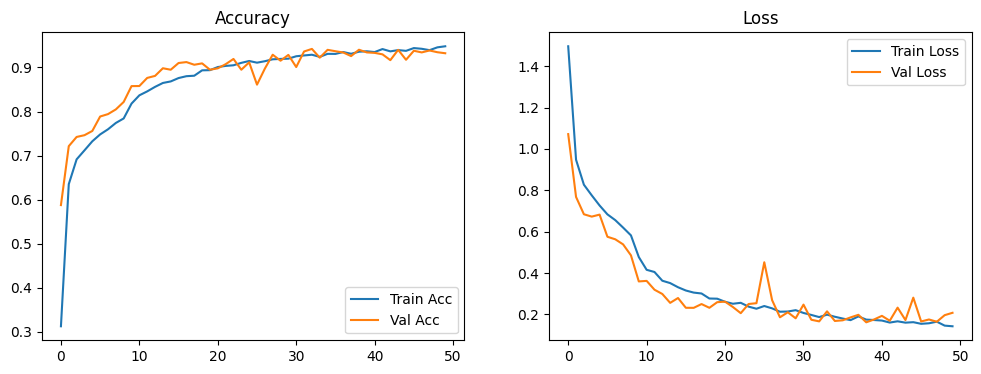

150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


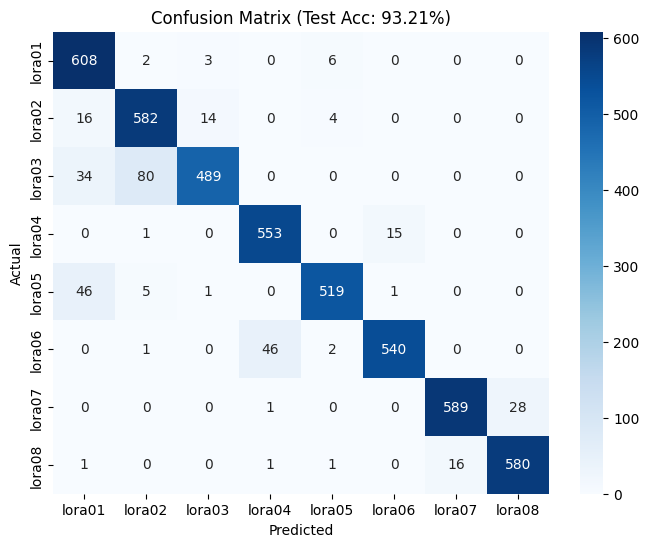

Final Test Accuracy: 93.21


In [ ]:
# Train model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Confusion Matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=TARGET_BOARDS, yticklabels=TARGET_BOARDS)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Test Acc: {np.mean(y_pred == y_test)*100:.2f}%)')
plt.show()

# Final test accuracy output
print(f"Final Test Accuracy: {np.mean(y_pred == y_test)*100:.2f}")

 Save Model (optional)



In [ ]:
# Define where to save in your Shared Drive
SAVE_DIR= "/content/drive/Shared drives/2025 RF Fingerprinting Senior Design/Model/Trained Models"
#MODEL_NAME = "cnn_baseline_v1.h5"

FULL_PATH = os.path.join(SAVE_DIR, MODEL_NAME)

model.save(FULL_PATH, include_optimizer=False)
print(f"Model saved to: {FULL_PATH}")

NameError: name 'MODEL_NAME' is not defined

(Optional) Save accuracy data as csv for external plotting

In [ ]:
import pandas as pd

history_df = pd.DataFrame(history.history)

history_df.insert(0, 'epoch', range(1, len(history_df) + 1))

print("\n" + "="*40)
print("COPY THE DATA BELOW FOR GOOGLE SHEETS")
print("="*40)
print(history_df.to_csv(index=False, sep='\t'))
print("="*40)

csv_path = "/content/training_metrics_6_layer_60epoch.csv"
history_df.to_csv(csv_path, index=False)
print(f"\nCSV file also saved to: {csv_path}")

# Task
Import the `EarlyStopping` callback from `tensorflow.keras.callbacks` and integrate it into the model training pipeline, ensuring that the model training stops early if validation loss does not improve and the best weights are restored, resolving the `NameError` for `EarlyStopping`.

## Import EarlyStopping Callback

### Subtask:
Add `from tensorflow.keras.callbacks import EarlyStopping` to the main import cell (`B7MesdDC9O0q`) to make the `EarlyStopping` class available.


**Reasoning**:
The subtask is to add an import statement for `EarlyStopping` to the main import cell. I will use a `code_block` to modify cell `B7MesdDC9O0q` by adding the required import statement to the existing imports.



In [ ]:
import os
import shutil
import glob
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive

if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Path to the "extracted_data" folder containing board subfolders (lora01, lora02...)
DRIVE_ROOT = "/content/drive/Shared drives/2025 RF Fingerprinting Senior Design/Data Collection/extracted_data"

# Local temporary cache
LOCAL_CACHE = "/content/data_cache"

# Target boards (must match folder names in drive)
TARGET_BOARDS = ['lora01', 'lora02', 'lora03', 'lora04', 'lora05', 'lora06', 'lora07', 'lora08']
#TARGET_BOARDS = ['lora01', 'lora02', 'lora03', 'lora04']

# Number of training messages per board (default None for all data)
MESSAGES_PER_BOARD = None;

# Clean local cache to avoid mixing old data
if os.path.exists(LOCAL_CACHE):
    shutil.rmtree(LOCAL_CACHE)
os.makedirs(LOCAL_CACHE, exist_ok=True)

print(f"Scanning Drive Root: {DRIVE_ROOT}")

for board in TARGET_BOARDS:
    board_drive_path = os.path.join(DRIVE_ROOT, board)

    zip_files = glob.glob(os.path.join(board_drive_path, "*.zip"))

    if not zip_files:
        print(f"  No zips found for {board} in {board_drive_path}")
        continue

    print(f" {board}: Found {len(zip_files)} collection(s). Processing...")

    board_local_base = os.path.join(LOCAL_CACHE, board)
    os.makedirs(board_local_base, exist_ok=True)

    for zip_path in zip_files:
        # Get unique name (e.g., "lora08_250kHz_..._16-28-42")
        zip_name = os.path.splitext(os.path.basename(zip_path))[0]

        # Create a specific subfolder for this zip to prevent overwrites
        extract_path = os.path.join(board_local_base, zip_name)
        os.makedirs(extract_path, exist_ok=True)

        try:
            shutil.unpack_archive(zip_path, extract_path)
        except Exception as e:
            print(f"    Error extracting {zip_name}: {e}")

print("\n Data Ingestion Complete. All files ready on local disk.")

**Reasoning**:
The previous step successfully added the `EarlyStopping` import. Now, I need to re-run the cell where `EarlyStopping` was causing a `NameError` to ensure the fix is applied and the model definition and callback initialization proceed without errors. This will move towards integrating the EarlyStopping callback into the model training pipeline.



In [ ]:
if len(X) == 0:
    raise ValueError("No data loaded! Please check Drive path.")

# Random split
# Train (70%), Val (15%), Test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train: {X_train.shape[0]} | Val: {X_val.shape[0]} | Test: {X_test.shape[0]}")

# Define CNN
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = len(TARGET_BOARDS)

model = Sequential([
    # Conv Block 1
    Conv1D(64, kernel_size=7, activation='relu', input_shape=input_shape),
    MaxPooling1D(pool_size=2),

    # Conv Block 2
    Conv1D(64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),

    # Conv Block 3
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    # Conv Block 4
    Conv1D(filters=256, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    # Conv Block 5
    Conv1D(filters=512, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    # Conv Block 6
    Conv1D(filters=1024, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    # Global Pooling
    GlobalAveragePooling1D(),

    # Classifier
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Define Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', # Monitor validation loss
    patience=10,        # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity.
)

**Reasoning**:
The previous step successfully added the `EarlyStopping` import. Now, I will re-run the cell defining the model and initializing the `EarlyStopping` callback to confirm the `NameError` is resolved and the callback is ready for use in training.



In [ ]:
if len(X) == 0:
    raise ValueError("No data loaded! Please check Drive path.")

# Random split
# Train (70%), Val (15%), Test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train: {X_train.shape[0]} | Val: {X_val.shape[0]} | Test: {X_test.shape[0]}")

# Define CNN
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = len(TARGET_BOARDS)

model = Sequential([
    # Conv Block 1
    Conv1D(64, kernel_size=7, activation='relu', input_shape=input_shape),
    MaxPooling1D(pool_size=2),

    # Conv Block 2
    Conv1D(64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),

    # Conv Block 3
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    # Conv Block 4
    Conv1D(filters=256, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    # Conv Block 5
    Conv1D(filters=512, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    # Conv Block 6
    Conv1D(filters=1024, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    # Global Pooling
    GlobalAveragePooling1D(),

    # Classifier
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Define Early Stopping callback
#early_stopping = EarlyStopping(
#    monitor='val_loss', # Monitor validation loss
#    patience=10,        # Number of epochs with no improvement after which training will be stopped
#    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity.
#)

**Reasoning**:
The `EarlyStopping` callback has been successfully defined. The next logical step is to integrate it into the model training by adding it to the `callbacks` parameter in the `model.fit()` function, which is located in cell `QWWWuEthDIu7`.



Epoch 1/50
698/698 ━━━━━━━━━━━━━━━━━━━━ 31s 33ms/step - accuracy: 0.2560 - loss: 1.6638 - val_accuracy: 0.5843 - val_loss: 1.0376
Epoch 2/50
698/698 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.5956 - loss: 1.0346 - val_accuracy: 0.7452 - val_loss: 0.7217
Epoch 3/50
698/698 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.6888 - loss: 0.8109 - val_accuracy: 0.7684 - val_loss: 0.6289
Epoch 4/50
698/698 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.7232 - loss: 0.7229 - val_accuracy: 0.7904 - val_loss: 0.5550
Epoch 5/50
698/698 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.7451 - loss: 0.6597 - val_accuracy: 0.8123 - val_loss: 0.5039
Epoch 6/50
698/698 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.7584 - loss: 0.6237 - val_accuracy: 0.8205 - val_loss: 0.4536
Epoch 7/50
698/698 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.7799 - loss: 0.5622 - val_accuracy: 0.8324 - val_loss: 0.4270
Epoch 8/50
698/698 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.7950 - loss: 0.5236 - 

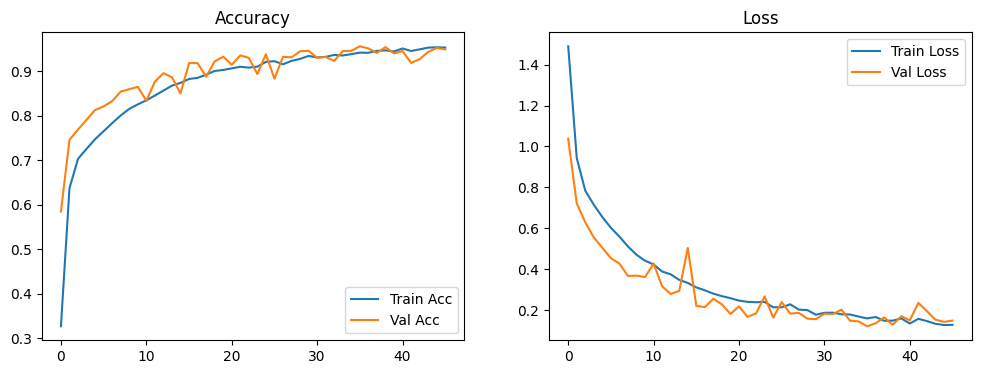

150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


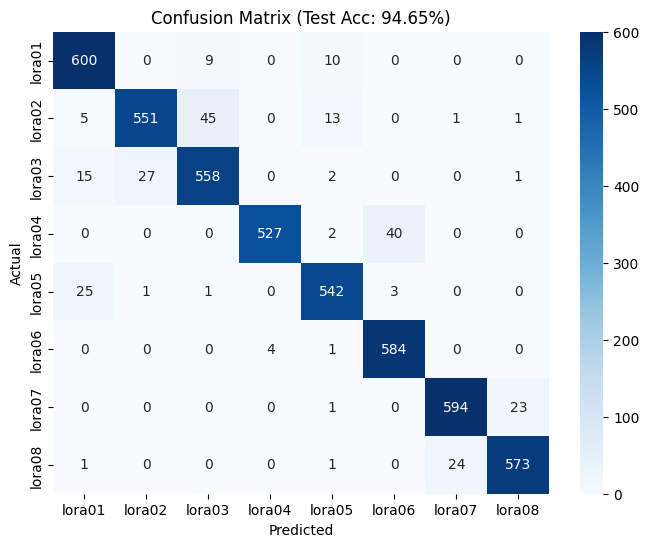

Final Test Accuracy: 94.65


In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    #callbacks=[early_stopping],
    verbose=1
)

# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Confusion Matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=TARGET_BOARDS, yticklabels=TARGET_BOARDS)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Test Acc: {np.mean(y_pred == y_test)*100:.2f}%)')
plt.show()

# Final test accuracy output
print(f"Final Test Accuracy: {np.mean(y_pred == y_test)*100:.2f}")